<a href="https://colab.research.google.com/github/pathilink/MBA_USP-Esalq_TCC/blob/main/notebook/findex_clustering_financial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering: extracting patterns from data

## Libraries

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler # standardizing features
from scipy.cluster.hierarchy import dendrogram, linkage # hierarchical clustering

from sklearn.preprocessing import Normalizer # normalize data
from sklearn.cluster import KMeans # knn
from sklearn import metrics # validation

from sklearn.decomposition import PCA

import random
seed_value = 18

# 1. Python
random.seed(seed_value)

# 2. Numpy
np.random.seed(seed_value)

# max display
# pd.set_option('display.max_columns', None)
pd.set_option("display.max_rows", None)

## Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# read file
df = pd.read_csv('/content/drive/My Drive/TCC/data/micro_bra_prepared.csv')
df.head(10)

,wgt,female,age,educ,inc_q,emp_in,account,account_fin,account_mob,fin1_1a,...,receive_wages,receive_transfers,receive_pension,receive_agriculture,pay_utilities,remittances,mobileowner,internetaccess,anydigpayment,merchantpay_dig
0,0,2,26,2,3,1,1,1,1,1,...,1,4,4,4,1,1,1,1,1,1
1,0,2,25,3,5,1,1,1,0,1,...,1,3,4,4,4,5,1,1,1,1
2,5,1,52,1,1,2,1,1,0,-1,...,4,1,4,4,2,5,1,2,1,0
3,0,2,23,2,3,1,1,1,0,-1,...,3,1,4,4,4,4,1,1,1,0
4,1,2,15,2,5,2,1,1,0,2,...,4,4,4,4,4,5,1,1,1,1
5,0,1,23,2,3,1,1,1,1,2,...,1,4,4,4,1,5,1,1,1,1
6,1,1,48,1,2,1,1,1,0,-1,...,2,1,4,4,2,4,1,2,1,0
7,0,1,39,2,4,1,1,1,1,1,...,1,1,4,4,1,1,1,1,1,1
8,0,2,44,2,5,1,1,1,1,1,...,1,4,4,4,1,5,1,1,1,1
9,0,1,56,3,5,1,1,1,0,2,...,1,4,4,4,1,5,1,1,1,1


In [5]:
# select female only and drop col
df = df.query('female == 1').drop('female', axis=1)
df.head()

,wgt,age,educ,inc_q,emp_in,account,account_fin,account_mob,fin1_1a,fin1_1b,...,receive_wages,receive_transfers,receive_pension,receive_agriculture,pay_utilities,remittances,mobileowner,internetaccess,anydigpayment,merchantpay_dig
2,5,52,1,1,2,1,1,0,-1,-1,...,4,1,4,4,2,5,1,2,1,0
5,0,23,2,3,1,1,1,1,2,2,...,1,4,4,4,1,5,1,1,1,1
6,1,48,1,2,1,1,1,0,-1,-1,...,2,1,4,4,2,4,1,2,1,0
7,0,39,2,4,1,1,1,1,1,2,...,1,1,4,4,1,1,1,1,1,1
9,0,56,3,5,1,1,1,0,2,2,...,1,4,4,4,1,5,1,1,1,1


In [6]:
print('The dataframe has {} rows and {} columns.'.format(df.shape[0], df.shape[1]))

The dataframe has 475 rows and 71 columns.


In [7]:
df.columns

Index(['wgt', 'age', 'educ', 'inc_q', 'emp_in', 'account', 'account_fin',
       'account_mob', 'fin1_1a', 'fin1_1b', 'fin2', 'fin4', 'fin4a', 'fin5',
       'fin6', 'fin7', 'fin8', 'fin8a', 'fin8b', 'fin9', 'fin9a', 'fin10',
       'fin10a', 'fin10b', 'fin14_1', 'fin14_2', 'fin14a', 'fin14a1', 'fin14b',
       'fin14c', 'fin14c_2', 'fin16', 'fin17a', 'fin17b', 'fin20', 'fin22a',
       'fin22b', 'fin24', 'fin24a', 'fin24b', 'fin26', 'fin28', 'fin30',
       'fin31a', 'fin31b', 'fin31b1', 'fin32', 'fin33', 'fin34a', 'fin34b',
       'fin37', 'fin38', 'fin42', 'fin44a', 'fin44b', 'fin44c', 'fin44d',
       'fin45', 'fin45_1', 'saved', 'borrowed', 'receive_wages',
       'receive_transfers', 'receive_pension', 'receive_agriculture',
       'pay_utilities', 'remittances', 'mobileowner', 'internetaccess',
       'anydigpayment', 'merchantpay_dig'],
      dtype='object')

In [8]:
# columns to drop for clustering
non_finance_columns = [
    'wgt',
    'age',
    'educ',
    'emp_in'
    ]

# drop columns for analysis
temp_df = df.drop(columns=non_finance_columns)

# new dataframe shape
print('The new dataframe has {} rows and {} columns.'.format(temp_df.shape[0], temp_df.shape[1]))

The new dataframe has 475 rows and 67 columns.


## Modeling

### Pre-processing

In [9]:
# Standardizing data, so that all features have equal weight. This is important for modelling.
# Otherwise, one feature would be considered much more important than other one, and would introduce bias.
# scaler = StandardScaler()
# df_std = scaler.fit_transform(df)
# df_std

In [10]:
# pre-processing: normalize data between 0 and 1
# if the data is not in the same range, the clustering algorithm will not give good results
values = Normalizer().fit_transform(temp_df.values)  # <-- better results than StandardScaler()
values


array([[0.0625    , 0.0625    , 0.0625    , ..., 0.125     , 0.0625    ,
        0.        ],
       [0.19166297, 0.06388766, 0.06388766, ..., 0.06388766, 0.06388766,
        0.06388766],
       [0.14106912, 0.07053456, 0.07053456, ..., 0.14106912, 0.07053456,
        0.        ],
       ...,
       [0.28444006, 0.05688801, 0.05688801, ..., 0.05688801, 0.05688801,
        0.05688801],
       [0.20134682, 0.06711561, 0.06711561, ..., 0.06711561, 0.06711561,
        0.06711561],
       [0.29329423, 0.07332356, 0.07332356, ..., 0.07332356, 0.07332356,
        0.07332356]])

### Hierarchical Clustering

In [11]:
# Perform Hierarchical Clustering. The results are returned as a linkage matrix.
hier_clust = linkage(values, method = 'ward')

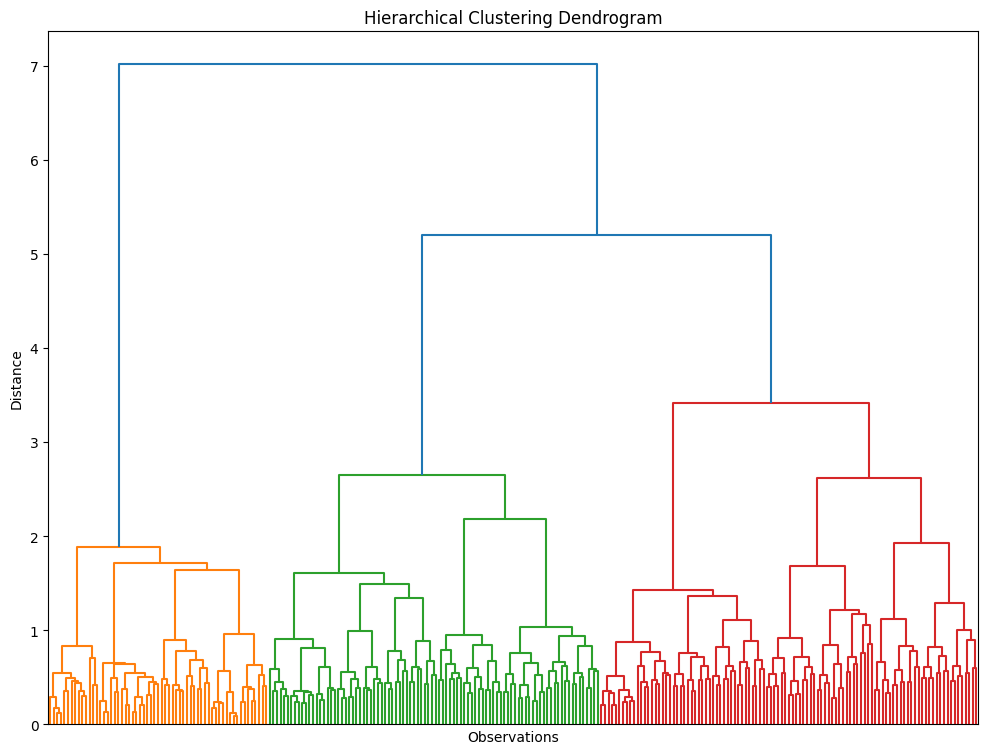

In [12]:
# We plot the results from the Hierarchical Clustering using a Dendrogram.
# We truncate the dendrogram for better readability. The level p shows only the last p merged clusters
# We also omit showing the labels for each point.
plt.figure(figsize = (12,9))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Observations')
plt.ylabel('Distance')
dendrogram(hier_clust,
           truncate_mode = 'level',
           p = 8,
           show_leaf_counts = False,
           no_labels = True)
plt.show()

### K-Nearest Neighbors

In [13]:
# Perform K-means clustering. We consider 1 to 10 clusters, so our for loop runs 10 iterations.
# In addition we run the algortihm at many different starting points - k means plus plus.
# And we set a random state for reproducibility.
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++',  n_init='auto', random_state=seed_value)
    kmeans.fit(values)
    wcss.append(kmeans.inertia_)

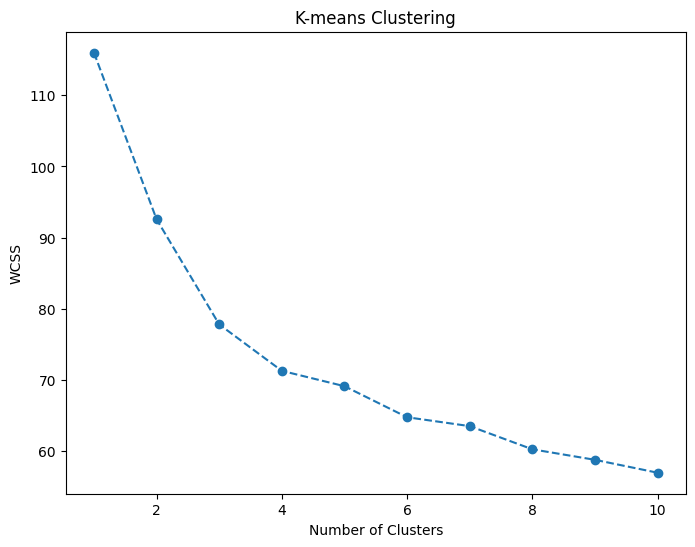

In [14]:
# Plot the Within Cluster Sum of Squares for the different number of clusters.
# From this plot we choose the number of clusters.
# We look for a kink in the graphic, after which the descent of wcss isn't as pronounced.
plt.figure(figsize = (8,6))
plt.plot(range(1, 11), wcss, marker = 'o', linestyle = '--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS') # Soma de quadrados dentro do cluster
plt.title('K-means Clustering')
plt.show()

In [15]:
# the data was not partitioned between training and test because there is no target variable

kmeans = KMeans(n_clusters=3, n_init=10, max_iter=300, random_state=seed_value)
y_pred = kmeans.fit_predict(values)

# clusters
labels = kmeans.labels_

### Validation

Existing validation metrics are divided into two categories: external and internal metrics.

**External metrics** need labels to perform calculations and generate validation. As there are no labels, they will not be used in this project. Internal metrics, on the other hand, are independent of labels, although they have a more complex structure.

**Internal metrics** are based on two validation criteria. The first is **compactness**, which tells us how close the points are in the same cluster - the closer the points, the more compact it is.

The second validation criterion is **separation**, which indicates how well separated the points in different clusters are. The idea is exactly the opposite of compactness: the further apart the clusters are from each other, the better. This means that they are more diverse.

<br>

**Silhouette coefficient** (compactness)

$$s = \frac{\beta - \alpha}{max(\alpha, \beta)}$$

* $\alpha$ is the average distance between the point and all the other points in the _same_ cluster.

* $\beta$ is the average distance between the point and all the other points in the _nearest_ cluster.

* Use the Euclidean distance.

* <font color='RoyalBlue'>The result is always between -1 and 1. When the silhouette value is positive and closer to 1, the better, the more separated the clusters are.</font>

<br>

**Davies-Bouldin index** (separation)

$$DB = \frac{1}{k}\sum_{i=1}^{k}max{_i}{_\ne}{_j}R{_i}{_j}$$

* "R" takes another formula to calculate, and basically gives us a measure of similarity between two clusters, "i" and "j".

* $R{_i}{_j} = \frac{{s}{_i} + {s}{_j}} {{d}{_i}{_j}}$

* Use the Euclidean distance.

* <font color='RoyalBlue'>The closer to zero, the better.</font>


<br>

**Euclidean distance**

$$d(A, B) = \sqrt{(x_B - x_A)² + (y_B - y_A)²}$$

<br>

**Calinski-Harabasz index** (compactness & separation)

$$s = \frac{tr(B_k)}{tr(W_k)} \times \frac{n_E - k}{k - 1}$$

* $n_E$: the number of elements in the cluster

* $k$: number of clusters

* $B_k = \sum_{q=1}^{k}n_q(c_q - c_E)(c_q - c_E)^T$

  * $B_k$: dispersion of elements between clusters
  * k: number of clusters
  * q: cluster
  * nq: number of elements in the cluster
  * cq: cluster centroid
  * ce: centroid of elements

* $W_k = \sum_{q=1}^{k}\sum_{x \in C_q}(x - c_q)(x - c_q)^T$

  * $W_k$: dispersion of elements within clusters
  * k: number of clusters
  * q: cluster

* It takes into account the dispersion of the points within a cluster, both in the points within a specific cluster and between different clusters, also considering compactness and separation.

* <font color='RoyalBlue'>It's best if the value is as high as possible.</font>

In [16]:
# Silhouette coefficient
# result > 0 indicates that the cluster is good according to this metric.
silhouette = metrics.silhouette_score(values, labels, metric='euclidean')
silhouette

0.1948471851507524

In [17]:
# Davies-Bouldin index
# closer to zero better.
dbs = metrics.davies_bouldin_score(values, labels)
dbs

1.8958876453205822

In [18]:
# Calinski-Harabasz index
# as high as possible
calinski = metrics.calinski_harabasz_score(values, labels)
calinski

115.6588416554077

#### Relative assessment

The value of the metrics is compared based on different configurations of the algorithm. The idea is to adjust the algorithm's parameters to obtain the best results.

In this case, the number of clusters will be changed, as this is the parameter that has the most impact.

<font color='RoyalBlue'>You choose one of the configurations to move on and carry out other validations.</fonte>

In [19]:
def clustering_algorithm(n_clusters, dataset):
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, max_iter=300)
    labels = kmeans.fit_predict(dataset)
    s = metrics.silhouette_score(dataset, labels, metric='euclidean')
    dbs = metrics.davies_bouldin_score(dataset, labels)
    calinski = metrics.calinski_harabasz_score(dataset, labels)
    return s, dbs, calinski

In [20]:
s0, dbs0, calinski0 = clustering_algorithm(2, values)
s0, dbs0, calinski0

(0.2499076062046204, 1.3755275019815179, 127.30305866607925)

In [21]:
# configuration chosen - following the results of the dendogram and the elbow method
s1, dbs1, calinski1 = clustering_algorithm(3, values)
s1, dbs1, calinski1

(0.1948471851507524, 1.895887645320582, 115.65884165540771)

In [22]:
s2, dbs2, calinski2 = clustering_algorithm(4, values)
s2, dbs2, calinski2

(0.177543537073693, 2.067176493151905, 98.47953352829553)

In [23]:
s3, dbs3, calinski3 = clustering_algorithm(6, values)
s3, dbs3, calinski3

(0.17526276729640555, 1.9911154720987667, 76.97905848520051)

In [24]:
s4, dbs4, calinski4 = clustering_algorithm(7, values)
s4, dbs4, calinski4

(0.15128734254780024, 2.0678305727364745, 68.96992309356772)

#### Cluster structure

Another form of validation is to compare the values we get from our dataset with others from a random database. <font color='RoyalBlue'>The idea is that we can ensure that our dataset has better metrics, and therefore a structure that can be clustered.</font>

There is a big difference between the original database and the random set, which is good for validation.

For the random set the silhoutte value was approximately 0.19 and for the original database 0.45. This shows that having a positive value is not always enough.

In [25]:
random_data = np.random.rand(475, 67) # same n rows and cols of temp_df
s, dbs, calinski = clustering_algorithm(3, random_data)
print(s, dbs, calinski)
print(s1,dbs1, calinski1)

0.014572132536090056 6.532350819464714 7.7543760578260175
0.1948471851507524 1.895887645320582 115.65884165540771


#### Cluster stability

The database is divided and KMeans is run for each of these divisions in order to obtain similar results for the metrics, so KMeans must behave similarly in each division in order to achieve validation.

<font color='RoyalBlue'>If the values in the three columns are similar and the metrics are different, this indicates that the cluster is valid.</font>

In [26]:
set1, set2, set3 = np.array_split(values, 3)
s1, dbs1, calinski1 = clustering_algorithm(3, set1)
s2, dbs2, calinski2 = clustering_algorithm(3, set2)
s3, dbs3, calinski3 = clustering_algorithm(3, set3)
print(s1, dbs1, calinski1)
print(s2, dbs2, calinski2)
print(s3, dbs3, calinski3)

0.207048082755194 1.7924799151814061 41.633968027456596
0.1937193842508284 1.9158842850392943 39.29236495545569
0.19786647254739692 1.8710504639671754 38.660284298596274


## Analyzing the values

<font color='RoyalBlue'>Strategy for selecting the most significant attribute and analyzing it:</font>

We have the value of each of the 16 attributes of the 5 clusters. We will observe the variance of the centroids for a given attribute, i.e. we will collect an attribute and check how it behaves in the different clusters.

For example, if we take the first cluster with a value of 1.60024706e-01 for the first "BALANCE" attribute.

The next cluster will already be very different, and the same goes for the following ones.

Since we're going to analyze variance, we'll look for an attribute where the values are different between the clusters, so that we have a better chance of observing the particularities of each group.

For example, we can see that we have customers who spend a lot in one cluster and those who spend little in another. However, there may be some other attribute where the difference isn't significant and won't help or even hinder our interpretation.

So we'll use the variance calculation. <font color='RoyalBlue'>Those attributes with the greatest variance will be used.</font>

In [27]:
# selects the KMeans centroids of each of the clusters
centroids = kmeans.cluster_centers_
centroids

array([[ 0.15319998,  0.02690245,  0.02466663,  0.0045425 , -0.06500595,
        -0.06500595,  0.13266072, -0.06500595, -0.06500595, -0.06500595,
        -0.06500595, -0.06500595, -0.06500595, -0.06500595, -0.06500595,
        -0.06500595, -0.06500595, -0.06500595, -0.06500595, -0.06500595,
         0.12780074, -0.05837248,  0.1240586 ,  0.12768764,  0.12283846,
        -0.04429401, -0.04639904,  0.12932282,  0.12839795,  0.12847455,
         0.11910018,  0.12651187,  0.11502151,  0.23801949,  0.06409874,
         0.06065966,  0.12460869,  0.12005439,  0.09101297,  0.03726244,
         0.04667568, -0.03335168,  0.1190275 , -0.03273531, -0.03352223,
        -0.03205276,  0.114756  ,  0.12558484,  0.12929617,  0.10069872,
         0.10190176,  0.10191916,  0.1303267 ,  0.12914495,  0.08587837,
         0.00811059,  0.02045122,  0.23945369,  0.22148705,  0.24875583,
         0.25859234,  0.16873698,  0.28797062,  0.07337121,  0.08859651,
         0.02690245,  0.00221116],
       [ 0.20738

## Selecting variables

We will select the variables with the highest variance, i.e. those with a significant difference between the clusters. The most relevant ones will be used for the detailed analysis of the clusters.

In [28]:
max = len(centroids[0])

col_list = []
var_list = []

for i in range(max):
    col_list.append(temp_df.columns.values[i])
    var_list.append(round(centroids[:, i].var(), 4))

# df variance
df_var = pd.DataFrame(
    {
        'variable': col_list,
        'variance': var_list
    }
)

# select variables with the greatest variance == most relevant
df_var.sort_values(by=['variance'], ascending=False)#.query('variance >= 0.0018')

,variable,variance
57,receive_wages,0.0066
5,fin1_1b,0.0066
45,fin34b,0.0062
19,fin10b,0.0061
43,fin33,0.0059
11,fin7,0.0054
9,fin5,0.0052
10,fin6,0.0049
15,fin9,0.0045
17,fin10,0.0044


**Dictionary of most relevant**

<br>

| Variable    | Label       | Definition  |
| :---------- | :---------- | :---------- |
| receive_wages | Received a wage payment | = 1 if the respondent received a wage payment into an account <br> = 2 if the respondent received a wage payment in cash only <br> = 3 if the respondent received a wage payment via some other method <br> = 4 if the respondent did not receive a wage payment <br> = 5 if the respondent does not know/refuses to answer <br> Note: This includes adults who received a wage payment in the past year. |
| fin1_1b | Opened first account to receive money from the government | = 1 if the respondent opened their first account at a financial institution (excluding mobile money accounts) to receive money from the government <br> =2 if no <br> =3 if don’t know <br> =4 if refused to answer <br> Note: Asked only of account owners (excluding mobile money accounts). |
| fin34b | Received wage payments to a mobile phone | = 1 if the respondent received any money from an employer, in the form of salary or wages for doing work through a mobile phone in the past year <br> =2 if no <br> =3 if don’t know <br> =4 if refused to answer <br> Note: Asked only of adults who received a wage payment. |
| fin10b | Used account to store money | = 1 if the respondent keeps money in their personal account (excluding mobile money accounts) <br> =2 if no <br> =3 if don’t know <br> =4 if refused to answer <br> Note: Asked only of account owners (excluding mobile money accounts). |
| fin33 | Received public sector wage payments | = 1 if the respondent received any money from the government, military, or public sector, in the form of salary or wages for doing work in the past year <br> =2 if no <br> =3 if don’t know <br> =4 if refused to answer <br> Note: Asked only of adults who received a wage payment. Adults not employed by the public sector are assumed to work for the private sector. |
| fin7 | Has a credit card | = 1 if the respondent has a credit card <br> =2 if no <br> =3 if don’t know <br> =4 if refused to answer <br> Note: Asked only of account owners (excluding mobile money accounts). |
| fin5 | Used a mobile phone or internet to access account | = 1 if the respondent has used a mobile phone or the Internet to make payments, buy things, or to send or receive money from or to their financial institution account (excluding mobile money accounts) in the past year <br> =2 if no <br> =3 if don’t know <br> =4 if refused to answer <br> Note: Asked only of account owners (excluding mobile money accounts). |
| fin6 | Used a mobile phone or internet to check account balance | = 1 if the respondent has checked their account balance using a mobile phone or the internet in the past year <br> =2 if no <br> =3 if don’t know <br> =4 if refused to answer <br> Note: Asked only of account owners (excluding mobile money accounts). |
| fin9 | Made any deposit into the account | = 1 if the respondent had money deposited into their account (excluding mobile money accounts) in the past year <br> =2 if no <br> =3 if don’t know <br> =4 if refused to answer <br> Note: Asked only of account owners (excluding mobile money accounts). This includes cash or electronic deposits, or any time money is put into their account(s) by themselves, by an employer, or another person or institution. |
| fin10 | Withdrew from the account | = 1 if the respondent had money withdrawn from their account (excluding mobile money accounts) in the past year <br> =2 if no <br> =3 if don’t know <br> =4 if refused to answer <br> Note: Asked only of account owners (excluding mobile money accounts). This includes cash withdrawals made in person using a debit card or mobile phone, electronic payments or purchases, checks, or any other sanctioned circumstance in which money is removed from the account(s) either by the account owner or by another person or institution. |
| fin1_1a | Opened first account to receive a wage payment | = 1 if the respondent opened their first account at a financial institution (excluding mobile money accounts) to receive a wage payment =2 if no <br> =3 if don’t know <br> =4 if refused to answer <br> Note: Asked only of account owners (excluding mobile money accounts). |
| fin9a | Make deposits into the account two or more times per month | = 1 if the respondent has money deposited into their account (excluding mobile money accounts) two or more times in a typical month <br> =2 if no <br> =3 if don’t know <br> =4 if refused to answer <br> Note: Asked only of account owners (excluding mobile money accounts). |
| fin14_2 | Paid digitally for an in-store purchase for the first time after COVID-19 | = 1 if the respondent exclusively used cash to pay for purchases in a store before the COVID-19 pandemic <br> = 2 if the respondent used other methods, such as a card or mobile phone to pay for purchases in a store before the COVID-19 pandemic <br> = 3 if the respondent does not know <br> = 4 if the respondent refuses to answer <br> Note: Asked only of adults who used a mobile phone or a debit or a credit card to pay for an in-store purchase. |
| fin4 | Used a debit card | =1 if the respondent used an ATM/debit card in the past year <br> =2 if no <br> =3 if don’t know <br> =4 if refused to answer <br> Note: Asked only of account owners (excluding mobile money accounts) that have an ATM/debit card. |
| fin10a | Withdrew from the account two or more times per month | = 1 if the respondent has money withdrawn from their account (excluding mobile money accounts) two or more times in a typical month <br> =2 if no <br> =3 if don’t know <br> =4 if refused to answer <br> Note: Asked only of account owners (excluding mobile money accounts). |
| fin34a | Received wage payments into an account | = 1 if the respondent received any money from an employer, in the form of salary or wages for doing work, directly into an account at a bank or another type of formal financial institution in the past year <br> =2 if no <br> =3 if don’t know <br> =4 if refused to answer <br> Note: Asked only of adults who received a wage payment. |
| fin14c_2 | Paid online for an online purchase for the first time after COVID-19 | = 1 if the respondent only used cash to pay upon delivery for online purchases before the COVID-19 pandemic <br> = 2 if the respondent had paid online for online purchases before the start of the COVID-19 pandemic <br> = 3 if the respondent does not know <br> = 4 if the respondent refuses to answer<br> Note: Asked only of adults who used a mobile phone or the Internet to buy something online and paid for it online. |
| fin4a | Used a debit card in-store | = 1 if the respondent used their ATM/debit card to pay for a purchase in a store in the past year <br> =2 if no <br> =3 if don’t know <br> =4 if refused to answer <br> Note: Asked only of account owners (excluding mobile money accounts) that used an ATM/debit card. |
| inc_q | Within-economy household income quintile | Respondent’s within-economy household income quintile (1 to 5) |
| fin8b | Paid credit card balances in full | = 1 if the respondent paid off all their credit card balances in full by their due date in the past year <br> =2 if no <br> =3 if don’t know <br> =4 if refused to answer <br> Note: Asked only of account owners (excluding mobile money accounts) who have a credit card. |


In [29]:
# add clusters to dataframe
temp_df['cluster'] = labels

# add back columns that were not selected
temp_df = pd.concat([temp_df, df[non_finance_columns]], axis=1)

temp_df.sample(3)

,inc_q,account,account_fin,account_mob,fin1_1a,fin1_1b,fin2,fin4,fin4a,fin5,...,remittances,mobileowner,internetaccess,anydigpayment,merchantpay_dig,cluster,wgt,age,educ,emp_in
545,5,1,1,0,1,2,1,1,1,1,...,1,1,1,1,1,2,0,58,3,1
335,2,1,1,0,1,1,1,1,1,1,...,5,1,1,1,1,1,0,42,2,1
797,4,0,0,0,-1,-1,2,-1,-1,-1,...,5,1,1,0,0,0,0,50,3,1


## Describing

In [30]:
# numeric variable
temp_df.groupby("cluster")["age"].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,90.0,47.000000,15.422878,15.0,37.25,48.0,57.75,86.0
1,221.0,44.733032,16.994551,15.0,32.00,44.0,58.00,85.0
2,164.0,37.207317,13.750393,15.0,25.00,36.0,45.00,80.0


In [31]:
result_df = temp_df.groupby("cluster")["age"].agg(['mean', 'std'])
result_df

,mean,std
cluster,,
0,47.000000,15.422878
1,44.733032,16.994551
2,37.207317,13.750393


In [32]:
pd.crosstab(temp_df['cluster'], temp_df['educ'])

educ,1,2,3,4,5
cluster,,,,,
0,30,51,9,0,0
1,38,118,61,4,0
2,3,77,83,0,1


In [33]:
pd.crosstab(temp_df['cluster'], temp_df['emp_in'])

emp_in,1,2
cluster,,
0,61,29
1,146,75
2,147,17


In [34]:
temp_df.groupby('cluster')[['educ', 'emp_in']].apply(lambda x: x.mode()) #'age',

,,educ,emp_in
cluster,,,
0,0,2,1
1,0,2,1
2,0,3,1


In [35]:
# list categorical variable of most relevant
categorical_variables = df_var.sort_values(by=['variance'], ascending=False).query('variance >= 0.0018 & variable != "age"')['variable'].tolist()
categorical_variables

['receive_wages',
 'fin1_1b',
 'fin34b',
 'fin10b',
 'fin33',
 'fin7',
 'fin5',
 'fin6',
 'fin9',
 'fin10',
 'fin1_1a',
 'fin9a',
 'fin14_2',
 'fin4',
 'fin10a',
 'fin34a',
 'fin14c_2',
 'fin4a',
 'inc_q',
 'fin8b']

In [36]:
# categorical variables
temp_df.groupby('cluster')[categorical_variables].apply(lambda x: x.mode())

,,receive_wages,fin1_1b,fin34b,fin10b,fin33,fin7,fin5,fin6,fin9,fin10,fin1_1a,fin9a,fin14_2,fin4,fin10a,fin34a,fin14c_2,fin4a,inc_q,fin8b
cluster,,,,,,,,,,,,,,,,,,,,,
0,0,4,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,2,-1
1,0,4,2,-1,2,-1,1,1,1,1,1,1,2,2,1,1,-1,-1,1,5,-1
2,0,1,2,2,1,2,1,1,1,1,1,1,1,2,1,1,1,2,1,5,1


In [37]:
# Has an account
# = 1 if the respondent has an account at a financial institution, a mobile money account, or both
# = 0 if the respondent does not have an account
pd.crosstab(temp_df['cluster'], temp_df['account'])

account,0,1
cluster,,
0,54,36
1,0,221
2,0,164


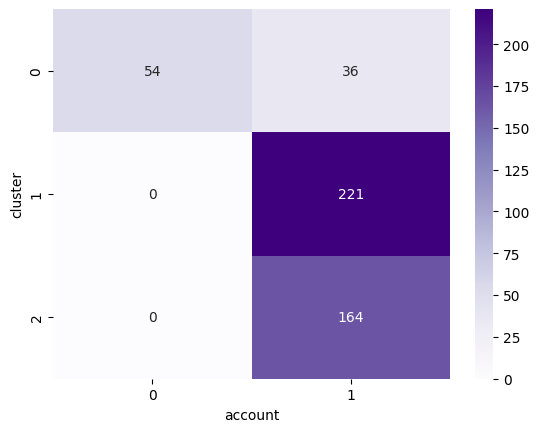

In [38]:
sns.heatmap(pd.crosstab(temp_df['cluster'], temp_df['account']), annot=True, fmt='d', cmap='Purples')
plt.show()

In [39]:
# Crie a tabela cruzada
account_cross_tab = pd.crosstab(temp_df['cluster'], temp_df['account'])

# Calcule os percentuais em relação ao total para cada categoria
round(account_cross_tab.apply(lambda x: x / x.sum(), axis=1) * 100, 2)


account,0,1
cluster,,
0,60.0,40.0
1,0.0,100.0
2,0.0,100.0


In [40]:
pd.crosstab(temp_df['cluster'], temp_df['receive_wages'])

receive_wages,1,2,3,4,5
cluster,,,,,
0,2,9,4,75,0
1,1,0,0,219,1
2,144,20,0,0,0


In [41]:
round(
    pd.crosstab(temp_df['cluster'], temp_df['receive_wages'])
    .apply(lambda x: x / x.sum(), axis=1) * 100
    , 1)

receive_wages,1,2,3,4,5
cluster,,,,,
0,2.2,10.0,4.4,83.3,0.0
1,0.5,0.0,0.0,99.1,0.5
2,87.8,12.2,0.0,0.0,0.0


In [42]:
pd.crosstab(temp_df['cluster'], temp_df['fin33'])

fin33,-1,1,2
cluster,,,
0,75,1,14
1,220,0,1
2,0,52,112


In [43]:
pd.crosstab(temp_df['cluster'], temp_df['inc_q'])

inc_q,1,2,3,4,5
cluster,,,,,
0,26,27,18,14,5
1,39,29,43,51,59
2,7,15,21,54,67


In [44]:
round(
    pd.crosstab(temp_df['cluster'], temp_df['inc_q'])
    .apply(lambda x: x / x.sum(), axis=1) * 100
    , 1)

inc_q,1,2,3,4,5
cluster,,,,,
0,28.9,30.0,20.0,15.6,5.6
1,17.6,13.1,19.5,23.1,26.7
2,4.3,9.1,12.8,32.9,40.9


In social statistics, income quintile groups are computed on the basis of the total equivalised disposable income attributed to each member of the household. The equivalised disposable income is the total income of a household, after tax and other deductions, that is available for spending or saving, divided by the number of household members converted into equalised adults.

<font color='RoyalBlue'>The first quintile group represents 20 % of the population with the lowest income (an income smaller or equal to the first cut-off value), and the fifth quintile group represents the 20 % of population with the highest income (an income greater than the fourth cut-off value).</font>

Source: https://ec.europa.eu/eurostat/statistics-explained/index.php?title=Glossary:Income_quintile_group (Access: December 29, 2023)

In [45]:
pd.crosstab(temp_df['cluster'], temp_df['fin8b'])

fin8b,-1,1,2,3
cluster,,,,
0,90,0,0,0
1,99,88,33,1
2,55,86,23,0


In [46]:
# Made or received a domestic remittance payment
# 1, 2, 3, 4 yes
# 5 no
# 6 does not know/refuses to answer
round(
    pd.crosstab(temp_df['cluster'], temp_df['remittances'])
    .apply(lambda x: x / x.sum(), axis=1) * 100
    , 1)

remittances,1,2,3,4,5,6
cluster,,,,,,
0,8.9,1.1,4.4,5.6,80.0,0.0
1,20.8,2.7,4.5,3.2,68.3,0.5
2,37.8,1.8,1.8,3.0,55.5,0.0


In [47]:
round(
    pd.crosstab(temp_df['cluster'], temp_df['fin24'])
    .apply(lambda x: x / x.sum(), axis=1) * 100
    , 1)

fin24,1,2,3,4,5,6,7,8,9
cluster,,,,,,,,,
0,3.3,27.8,37.8,4.4,3.3,6.7,7.8,6.7,2.2
1,13.6,28.5,28.5,12.7,5.4,4.5,3.2,3.2,0.5
2,19.5,17.7,31.1,18.9,4.9,6.1,1.2,0.6,0.0


In [48]:
# Has an account at a financial institution
# = 1 if the respondent had an account at a bank or at another type of financial
# institution, such as a credit union, a microfinance institution, a cooperative, or
# the post office (if applicable), or has a debit card
# = 0 if the respondent did not have an account
round(
    pd.crosstab(temp_df['cluster'], temp_df['account_fin'])
    .apply(lambda x: x / x.sum(), axis=1) * 100
    , 1)

account_fin,0,1
cluster,,
0,63.3,36.7
1,0.0,100.0
2,0.0,100.0


In [49]:
# Has a mobile money account
# = 1 if the respondent used mobile money services to pay bills or to send or
# receive money in the past year
# = 0 if the respondent did not use them
round(
    pd.crosstab(temp_df['cluster'], temp_df['account_mob'])
    .apply(lambda x: x / x.sum(), axis=1) * 100
    , 1)

account_mob,0,1
cluster,,
0,93.3,6.7
1,73.3,26.7
2,52.4,47.6


In [50]:
# Owns a mobile phone
# = 1 if the respondent owns a mobile phone
# = 2 if no
round(
    pd.crosstab(temp_df['cluster'], temp_df['mobileowner'])
    .apply(lambda x: x / x.sum(), axis=1) * 100
    , 1)

mobileowner,1,2
cluster,,
0,86.7,13.3
1,95.0,5.0
2,99.4,0.6


In [51]:
# Received a government transfer payment
# = 1 if the respondent received government transfers into an account
# = 2 if the respondent received government transfers in cash only
# = 3 if the respondent received government transfers via some other method
# = 4 if the respondent did not receive government transfers
# = 5 if the respondent does not know/refuses to answer
round(
    pd.crosstab(temp_df['cluster'], temp_df['receive_transfers'])
    .apply(lambda x: x / x.sum(), axis=1) * 100
    , 1)

receive_transfers,1,2,3,4,5
cluster,,,,,
0,14.4,4.4,3.3,77.8,0.0
1,24.0,5.0,2.7,67.4,0.9
2,18.3,1.8,4.3,75.6,0.0


In [52]:
round(
    pd.crosstab(temp_df['cluster'], temp_df['receive_pension'])
    .apply(lambda x: x / x.sum(), axis=1) * 100
    , 1)

receive_pension,1,2,3,4,5
cluster,,,,,
0,4.4,1.1,1.1,93.3,0.0
1,11.3,1.8,0.9,85.5,0.5
2,7.3,0.0,0.0,92.7,0.0


In [53]:
round(
    pd.crosstab(temp_df['cluster'], temp_df['receive_agriculture'])
    .apply(lambda x: x / x.sum(), axis=1) * 100
    , 1)

receive_agriculture,1,2,4
cluster,,,
0,0.0,1.1,98.9
1,1.8,1.4,96.8
2,0.6,0.6,98.8


Obs:

* Unanimemente o Cluster 1 não recebe pagamento de salário mas todas possuem conta. <font color='Red'>De onde vem o dinheiro para colocar na conta?</font>
  * 100% não vem do setor privado
  * 100% não vem do setor público
  * 32% recebeu algum tipo de transferência do governo
  * 31.2% fez ou recebeu uma remessa doméstica de pagamento
  * 11% recebeu pensão do governo
  * 2% recebeu pagamento pela venda de produtos agrícolas
  * Auxílio do governo? Inclusão social? SIM, também.
* Maioria do Cluster 0 não possui conta e nem recebe salário.

| Variable | Cluster 2 | Cluster 1 | Cluster 0 |
|-|-|-|-|
| age	| Média de 37 anos | Média de 44 anos | Média de 47 anos |
| educ | Ensino Superior ou acima | Ensino Médio | Ensino Médio |
| emp_in| Está no mercado de trabalho | Está no mercado de trabalho | Está no mercado de trabalho |
| receive_wages | Recebeu um pagamento de salário em uma conta | Não recebeu um pagamento de salário | Maioria não recebeu um pagamento de salário |
| <font color='Red'>account</font> | <font color='Red'>Todas possuem conta</font> | <font color='Red'>Todas possuem conta</font> | <font color='Red'>40% possui conta</font> |
| <font color='Red'>account_fin</font> | <font color='Red'>100% possui conta em instituição financeira</font> | <font color='Red'>100% possui conta em instituição financeira</font> | <font color='Red'>37% possui conta em instituição financeira</font> |
| <font color='Red'>account_mob</font> | <font color='Red'>52% possui conta mobile</font> | <font color='Red'>27% possui conta mobile</font> | <font color='Red'>7% possui conta mobile</font> |
| <font color='Red'>mobileowner</font> | <font color='Red'>0.6% não possui</font>| <font color='Red'>5% não possui</font>| <font color='Red'>13% não possui</font>|
| fin1_1b | Não abriu a 1a conta para receber benefício do governo | Não abriu a 1a conta para receber benefício do governo | Não aplicável |
| fin34b | Recebeu pagamento de salário em conta mobile | Não aplicável | Não aplicável |
| fin10b | Guarda dinheiro na conta | Não guarda dinheiro na conta | Não aplicável |
| fin33 | Maioria não recebe salário do setor público | Não aplicável | Maioria não aplicável |
| fin7 | Possui cartão de crédito | Possui cartão de crédito | Não aplicável |
| fin5 | Usa celular/internet para acessar a conta | Usa celular/internet para acessar a conta | Não aplicável |
| fin6 | Usa celular/internet para verificar a conta | Usa celular/internet para verificar a conta | Não aplicável |
| fin9 | Fez algum depósito na conta | Fez algum depósito na conta | Não aplicável |
| fin10 | Retirou dinheiro da conta | Retirou dinheiro da conta | Não aplicável |
| fin1_1a | Abriu a 1a conta para receber salário | Abriu a 1a conta para receber salário | Não aplicável |
| fin9a | Faz depósitos 2+ vezes ao mês | Não faz depósitos 2+ vezes ao mês | Não aplicável |
| fin14_2 | Usou cartão ou celular para pagar compras em loja antes da COVID-19 | Usou cartão ou celular para pagar compras em loja antes da COVID-19 | Não aplicável |
| fin4 | Usou cartão de débito no último ano | Usou cartão de débito no último ano | Não aplicável |
| fin10a | Retirou dinheiro 2+ vezes ao mês | Retirou dinheiro 2+ vezes ao mês | Não aplicável |
| fin34a | Maioria recebeu salário na conta | Não aplicável | Maioria não aplicável |
| fin14c_2 | Pgto online por compra online | Não aplicável | Não aplicável |
| fin4a | Usou débito em loja | Usou débito em loja | Não aplicável |
| inc_q | Pertence aos 40% da pop com renda mais alta | Maioria pertence ao 20% com mais renda, mas tb se distribui nos outros quintils | Pertence aos 40% da pop com renda mais baixa |
| fin8b | Pagou todo o saldo do cartão de crédito, mas algumas não se aplica | Maioria não se aplica, mas outras pagaram tudo | Não aplicável |

Variável em <font color='Red'>vermelho</font> indica que não está inclusa entre as mais relevantes na clusterização mas é importante para interpretação.